# Point matching for automatic fiducial registration

This is an important problem for doing thick PALM where we take data in slabs but each slab has to be individually drift corrected. We have an overall scaffold to which we need to align the data.

Ideally we'd generate a program that would do the following steps
1. Read in the data (or generate it ...)
    1. Read in slab data
    2. Read in scaffold data
2. Automatically find fiducials
    1. Do drift correction if it hasn't been done already
    2. localize fiducials in the scaffold
3. **Using the fiducials automatically align the slabs to the scaffold.**

The last point is the issue for this notebook. We'll be primarily working off the methods mentioned [here](https://en.wikipedia.org/wiki/Point_set_registration).

The main methods are:
1. [Iterative closest point](https://en.wikipedia.org/wiki/Iterative_closest_point)
    - http://connor-johnson.com/2014/06/06/an-iterative-closest-point-algorithm/
    - https://stackoverflow.com/questions/20120384/iterative-closest-point-icp-implementation-on-python
    - https://engineering.purdue.edu/kak/distICP/ICP-2.0.html
    - https://github.com/ClayFlannigan/icp
2. Robust point matching
    - http://scikit-image.org/docs/dev/auto_examples/transform/plot_matching.html
3. Kernel Correlation
4. Coherent Point Drift
    - https://github.com/Hennrik/Coherent-Point-Drift-Python
    - https://github.com/siavashk/pycpd

![](https://upload.wikimedia.org/wikipedia/commons/f/fe/Cpd_fish_affine.gif)

# Basics

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.transform

class AffineTransform(skimage.transform.AffineTransform):
    """Extending the skimage class with mat multiply and a few other properties"""

    def __matmul__(self, other):
        newmat = self.params @ other.params
        return AffineTransform(matrix=newmat)

    def __eq__(self, other):
        return np.array_equal(self.params, other.params)

    @property
    def inverse(self):
        return AffineTransform(matrix=np.linalg.inv(self.params))

    def __repr__(self):
        return self.params.__repr__()

    def __str__(self):
        string = ("<AffineTransform: translation = {}, rotation ={:.2f},"
                  " scale = {}, shear = {:.2f}>")
        return string.format(np.round(self.translation, 2), np.rad2deg(self.rotation),
                      np.round(np.array(self.scale), 2), np.rad2deg(self.shear))


AffineTransform.__init__.__doc__ = AffineTransform.__base__.__init__.__doc__
AffineTransform.__doc__ = AffineTransform.__base__.__doc__

In [2]:
def apply_transform(points, transform):
    """Apply the given affine transformation to the point set"""
    matrix = transform.params[:2, :2]
    offset = transform.translation[:, None]
    return matrix.dot(points) + offset

# Testing out the `pycpd` package

https://github.com/siavashk/pycpd (no idea if this is implemented correctly)

http://siavashk.github.io/2017/05/14/coherent-point-drift/ blog post explaining the math

Original paper: https://arxiv.org/pdf/0905.2635.pdf

**Note:** if the code follows the notation of the paper then $w$ is the weight of the uniform distribution that's included in the gaussian mixture model to model noise. We need to test a good default value for this parameter but 0.5 seems good from initial experiments (2D)

One thing they mention in the paper:
>We shall always prealign both point sets to zero mean and unit variance before the registration.

## Starting out with the fishy

In [3]:
from pycpd import affine_registration, deformable_registration, rigid_registration
from mpl_toolkits.mplot3d import Axes3D

In [5]:
import scipy.spatial.distance as distance

In [6]:
import numpy as np

In [114]:
# need to add translation only registration
class translation_registration(object):
    def __init__(self, X, Y, t=None, sigma2=None, maxIterations=100, tolerance=0.001, w=0):
        if X.shape[1] != Y.shape[1]:
            raise 'Both point clouds must have the same number of dimensions!'

        self.X             = X
        self.Y             = Y
        self.TY            = Y
        (self.N, self.D)   = self.X.shape
        (self.M, _)        = self.Y.shape
        self.t             = np.atleast_2d(np.zeros((1, self.D))) if t is None else t
        self.sigma2        = sigma2
        self.iteration     = 0
        self.maxIterations = maxIterations
        self.tolerance     = tolerance
        self.w             = w
        self.q             = 0
        self.err           = 0

    def register(self, callback):
        self.initialize()

        while self.iteration < self.maxIterations and self.err > self.tolerance:
            self.iterate()
            if callback:
                callback(iteration=self.iteration, error=self.err, X=self.X, Y=self.TY)

        return self.TY, np.atleast_2d(self.t), self.P

    def iterate(self):
        self.EStep()
        self.MStep()
        self.iteration += 1

    def MStep(self):
        self.updateTransform()
        self.transformPointCloud()
        self.updateVariance()

    def updateTransform(self):
        muX = np.divide(np.sum(np.dot(self.P, self.X), axis=0), self.Np)
        muY = np.divide(np.sum(np.dot(np.transpose(self.P), self.Y), axis=0), self.Np)

        self.XX = self.X - np.tile(muX, (self.N, 1))
        YY      = self.Y - np.tile(muY, (self.M, 1))

        self.A = np.dot(np.transpose(self.XX), np.transpose(self.P))
        self.A = np.dot(self.A, YY)

        self.YPY = np.dot(np.transpose(self.P1), np.sum(np.multiply(YY, YY), axis=1))

        self.t = np.transpose(muX) - np.transpose(muY)

    def transformPointCloud(self, Y=None):
        if Y is None:
            self.TY = self.Y + np.tile(np.transpose(self.t), (self.M, 1))
            return
        else:
            return Y + np.tile(np.transpose(self.t), (Y.shape[0], 1))

    def updateVariance(self):
        # needs work
        qprev = self.q

        trAR     = np.trace(self.A)
        xPx      = np.dot(np.transpose(self.Pt1), np.sum(np.multiply(self.XX, self.XX), axis =1))
        self.q   = (xPx - 2 * trAR + self.YPY) / (2 * self.sigma2) + self.D * self.Np/2 * np.log(self.sigma2)
        self.err = np.abs(self.q - qprev)

        self.sigma2 = (xPx - trAR) / (self.Np * self.D)

        if self.sigma2 <= 0:
            self.sigma2 = self.sigma_init = self.sigma_init * 2.0
            self.t = -self.Y.mean(axis=0) + self.X.mean(axis=0)
            #+np.random.randn(*self.t.shape) * np.sqrt(self.Y.var(axis=0) * self.sigma2 + self.X.mean(axis=0))
            #self.t = np.zeros_like(self.t)
            self.transformPointCloud()
    
    def initialize(self):
        self.TY = self.Y + np.repeat(self.t, self.M, axis=0)
        if not self.sigma2:
            XX = np.reshape(self.X, (1, self.N, self.D))
            YY = np.reshape(self.TY, (self.M, 1, self.D))
            XX = np.tile(XX, (self.M, 1, 1))
            YY = np.tile(YY, (1, self.N, 1))
            diff = XX - YY
            err  = np.multiply(diff, diff)
            self.sigma2 = np.sum(err) / (self.D * self.M * self.N)
            
        self.sigma_init = self.sigma2

        self.err  = self.tolerance + 1
        self.q    = -self.err - self.N * self.D/2 * np.log(self.sigma2)

    def EStep(self):
        P = np.zeros((self.M, self.N))

        for i in range(0, self.M):
            diff     = self.X - np.tile(self.TY[i, :], (self.N, 1))
            diff    = np.multiply(diff, diff)
            P[i, :] = P[i, :] + np.sum(diff, axis=1)

        c = (2 * np.pi * self.sigma2) ** (self.D / 2)
        c = c * self.w / (1 - self.w)
        c = c * self.M / self.N
        
        P = np.exp((-P / (2 * self.sigma2)))
        den = np.sum(P, axis=0)
        den = np.tile(den, (self.M, 1))
        den = np.maximum(np.finfo(float).eps, den)
        den += c

        self.P   = np.divide(P, den)
        self.Pt1 = np.sum(self.P, axis=0)
        self.P1  = np.sum(self.P, axis=1)
        self.Np  = max(np.finfo(float).eps, np.sum(self.P1))

In [115]:
a = np.arange(9).reshape(3,3)
a @ np.ones((3)) == a.sum(1)

array([ True,  True,  True], dtype=bool)

In [445]:
import scipy.spatial.distance as distance
import scipy.linalg as la

class BaseCPD(object):
    """A class that performs translation only coherent point drift
    
    Refs:
    """
    def __init__(self, X, Y):
        """
        
        Parameters
        X : ndarray (N, D)
            Fixed point cloud, an N by D array of N original observations in an n-dimensional space
        Y : ndarray (M, D)
            Moving point cloud, an M by D array of N original observations in an n-dimensional space
        """
        self.X = X
        self.Y = Y
        self.N, self.D = self.X.shape
        self.M, D = self.Y.shape
        assert D == self.D, "Point clouds have different dimensions"
    
    def updateTY(self):
        self.TY = self.Y @ self.B.T + self.translation
    
#     @property
#     def pGMM(self):
#         """The probability density of the gaussian mixture model along the fixed points"""
#         norm_factor = self.M * (2 * np.pi * self.var) ** (self.D / 2)
#         p_mat = np.exp(- self.dist_matrix / 2 / self.var) / norm_factor
#         # sum along the fixed points
#         return p_mat.sum(0)
    
#     @property
#     def p(self):
#         """The total probability including the uniform distribution"""
#         return self.w / self.N + (1 - self.w) * self.pGMM
    
    @property
    def dist_matrix(self):
        """This gives us a matrix of ||x - T(y)||**2, eq (1)"""
        # This gives us a matrix of ||x - y||**2, eq (1)
        # But we want the rows to be m and columns n
        dist_matrix = distance.cdist(self.TY, self.X, 'sqeuclidean')
        assert dist_matrix.shape == (self.M, self.N), "Error with dist_matrix"
        return dist_matrix
    
    def estep(self):
        """The posterior probabilities of the GMM components"""
        # save distance matrix to minimize computation
        dist_matrix = self.dist_matrix
        p_mat = np.exp(-dist_matrix / 2 / self.var)
        c = (2 * np.pi * self.var) ** (self.D / 2)
        c *= self.w / (1 - self.w)
        c *= self.M / self.N
        # sum along the moving points
        denominator = p_mat.sum(0, keepdims=True)
        if (denominator == 0).all():
            # if denominator is all zeros, which means p_mat is all zeros
            # then the final p should just be a uniform distribution
            # should log or warn user this is happening
            print("warn")
            p_old = np.ones_like(p_mat) / self.M 
        else:
            p_old = p_mat / (denominator + c)
        # compute Np, make sure it's neither zero or more than N
        self.Np = min(self.N, max(p_old.sum(), np.finfo(float).eps))
        # update Q so we can track convergence
        # equation (5)
        self.Q = (p_old * dist_matrix).sum() / 2 / self.var + self.Np * self.D * np.log(self.var) / 2
        self.p_old = p_old
        
    def updateB(self):
        """Update B matrix, this is the only method that needs to be overloaded"""
        raise NotImplementedError
        
    def mstep(self):
        # M-step update transformation and variance
        # these are the transposes of the equations on 
        # p. 2265
        p_old = self.p_old
        mu_x = (p_old @ self.X).sum(0, keepdims=True) / self.Np
        mu_y = (p_old.T @ self.Y).sum(0, keepdims=True) / self.Np
        # update the variance
        Xhat = self.Xhat = self.X - mu_x
        Yhat = self.Yhat = self.Y - mu_y
        
        self.A = A = Xhat.T @ p_old.T @ Yhat
        
        B = self.updateB()
        
        # calculate translation
        self.translation = (mu_x - mu_y @ B.T)
        
        self.var = np.trace(Xhat.T @ np.diag(p_old.sum(0)) @ Xhat) - np.trace(A @ B.T)
        self.var /= self.Np * self.D
        # make sure self.var is positive
        if self.var < np.finfo(float).eps:
            self.var = np.finfo(float).eps
            # self.var = self.init_var = self.init_var * 2
            # self.translation = -self.Y.mean(axis=0) + self.X.mean(axis=0)
            # print("Var small resetting to", self.var)
    
    def update(self):
        # E-step, compute p_old, Np, Q
        self.estep()
        self.mstep()
        self.updateTY()
        # Q_delta = np.abs((self.Q_old - self.Q) / self.Q_old)
        Q_delta = np.abs((self.Q_old - self.Q))
        self.Q_old = self.Q
        return Q_delta
    
    def register(self, tol=1e-6, maxiters=1000, init_var=None, weight=0):
        """perform the actual registration"""
        # update to the initial position
        self.updateTY()
        
        if init_var is None:
            init_var = self.dist_matrix.sum() / (self.D * self.N * self.M)
        
        self.var = self.init_var = init_var
            
        self.w = weight
        
        self.Q_old = np.finfo(float).eps
        
        for i in range(maxiters):
            # do iterations
            delta_Q = self.update()
            if delta_Q <= tol:
                break
            self.iteration = i


class TranslationCPD(BaseCPD):
    
    def updateB(self):
        """Update the A and B matrices, this is the only method that needs to be overloaded"""
        self.B = np.eye(self.D)
        return self.B
        
    def __call__(self, tol=1e-6, maxiters=1000, init_var=None, weight=0, translation=None):
        """perform the actual registration"""
        if translation is None:
            translation = np.ones((1, self.D))
        self.translation = translation
        self.B = np.eye(self.D)
        
        # run the registration
        self.register(tol, maxiters, init_var, weight)
        
        return self.TY, self.translation, self.p_old
    
    
class RigidCPD(BaseCPD):
    
    def updateB(self):
        """Update the A and B matrices, this is the only method that needs to be overloaded"""
        self.B = self.A @ self.Yhat
        return self.B
        
    def __call__(self, tol=1e-6, maxiters=1000, init_var=None, weight=0, translation=None):
        """perform the actual registration"""
        if translation is None:
            translation = np.ones((1, self.D))
        self.translation = translation
        self.B = np.eye(self.D)
        
        # run the registration
        self.register(tol, maxiters, init_var, weight)
        
        return self.TY, self.translation, self.p_old
    
    
class SimilarityCPD(BaseCPD):
    
    def updateB(self):
        """Update the A and B matrices, this is the only method that needs to be overloaded"""
        self.B = np.eye(self.D)
        return self.B
        
    def __call__(self, tol=1e-6, maxiters=1000, init_var=None, weight=0, translation=None):
        """perform the actual registration"""
        if translation is None:
            translation = np.ones((1, self.D))
        self.translation = translation
        self.B = np.eye(self.D)
        
        # run the registration
        self.register(tol, maxiters, init_var, weight)
        
        return self.TY, self.translation, self.p_old
    
    
class AffineCPD(BaseCPD):
    
    def updateB(self):
        """Update the A and B matrices, this is the only method that needs to be overloaded"""
        a = self.Yhat.T @ np.diag(self.p_old.sum(1)) @ self.Yhat
        # solve B = self.A @ np.inv(a) == B @ a = self.A == a.T @ B.T = self.A.T
        # self.B = la.solve(a.T, self.A.T).T
        # a is a symmetric matrix
        self.B = la.solve(a, self.A.T).T
        return self.B
        
    def __call__(self, tol=1e-6, maxiters=1000, init_var=None, weight=0, translation=None, B=None):
        """perform the actual registration"""
        if translation is None:
            translation = np.ones((1, self.D))
        self.translation = translation
        
        if B is None:
            B = np.eye(self.D)
        self.B = B
        
        # run the registration
        self.register(tol, maxiters, init_var, weight)
        
        return self.TY, self.translation, self.p_old
        
    

In [333]:
np.arange(10).reshape(2, 5)

array([0, 5])

In [309]:
def plot_results(X, Y, TY):
    
    if X.shape[-1] == 3:
        projection = "3d"
    else:
        projection = None
    fig = plt.figure(figsize=(4,8))
    ax0 = fig.add_subplot(211, projection=projection)
    ax1 = fig.add_subplot(212, projection=projection)
    
    ax0.scatter(*X.T, color='red')
    ax0.scatter(*Y.T, color='blue', marker="x")
    
    ax1.scatter(*X.T, color='red')
    ax1.scatter(*TY.T, color='blue', marker="x")
    ax0.set_aspect('equal', 'datalim')
    ax1.set_aspect('equal', 'datalim')

## Testing on a toy model for fiducials

In [310]:
import seaborn as sns
sns.set()

In [451]:
trans = np.random.rand(1, 2) * 1

ps1 = np.random.rand(20, 2)
ps2 = np.concatenate((ps1, np.random.rand(10, 2))) + trans

In [452]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0, init_var=None, translation=None)
reg1 = affine_registration(ps1, ps2, **kwargs1)
reg2 = AffineCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    %time result1 = reg1.register(None)
    %time result2 = reg2(**kwargs2)
if not np.array_equal(result1[1], result2[1]):
    print(reg1.iteration)
    print(reg2.iteration)

#     plot_results(ps1, ps2, result1[0])
#     plot_results(ps1, ps2, result2[0])

CPU times: user 122 ms, sys: 16.2 ms, total: 138 ms
Wall time: 80.7 ms
CPU times: user 70 ms, sys: 9.15 ms, total: 79.2 ms
Wall time: 48.2 ms
56
98


56
98


<IPython.core.display.Javascript object>


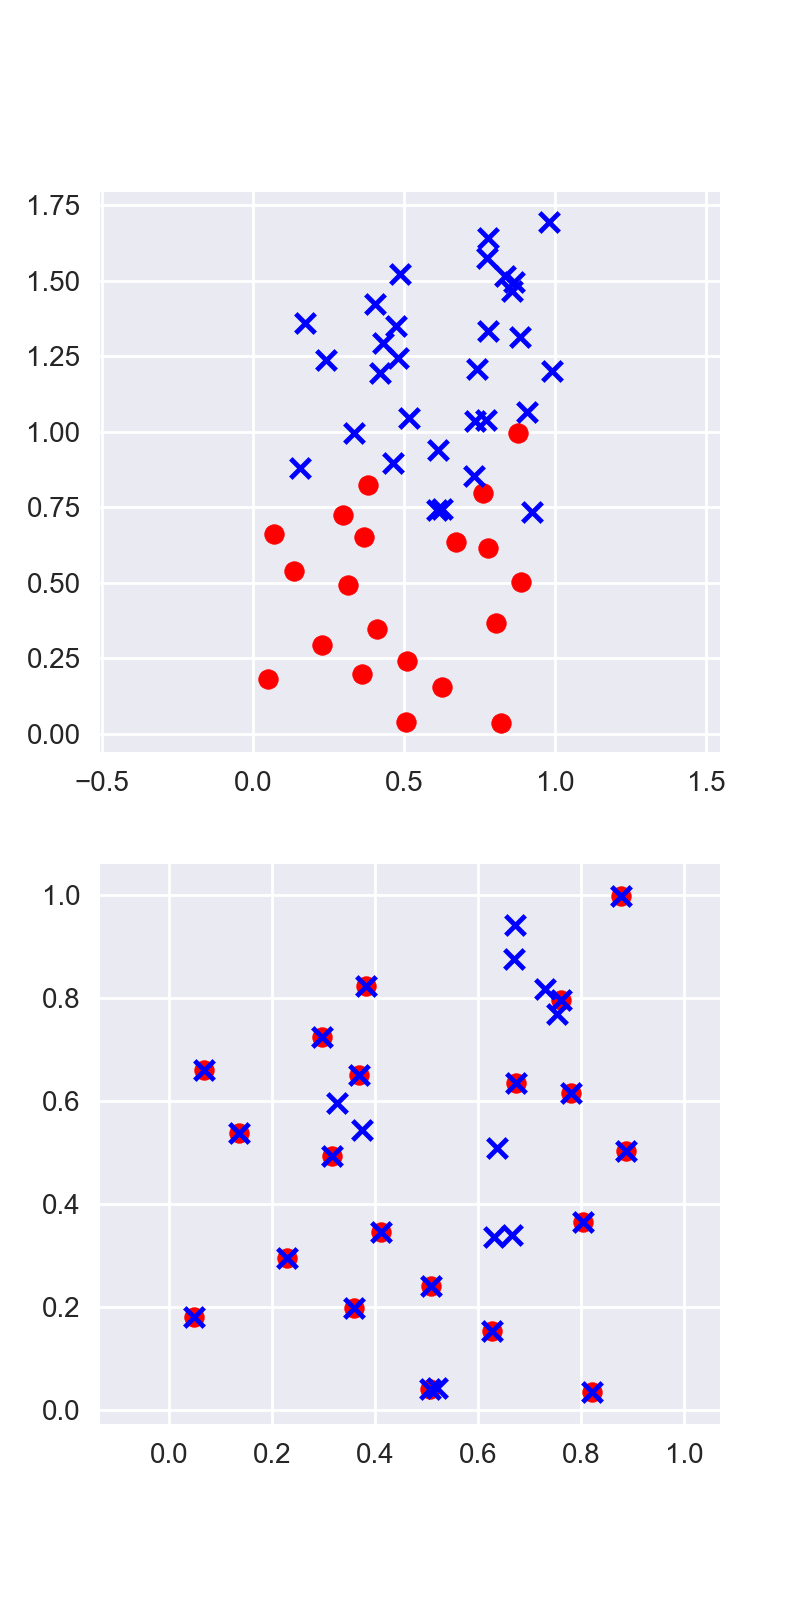

<IPython.core.display.Javascript object>


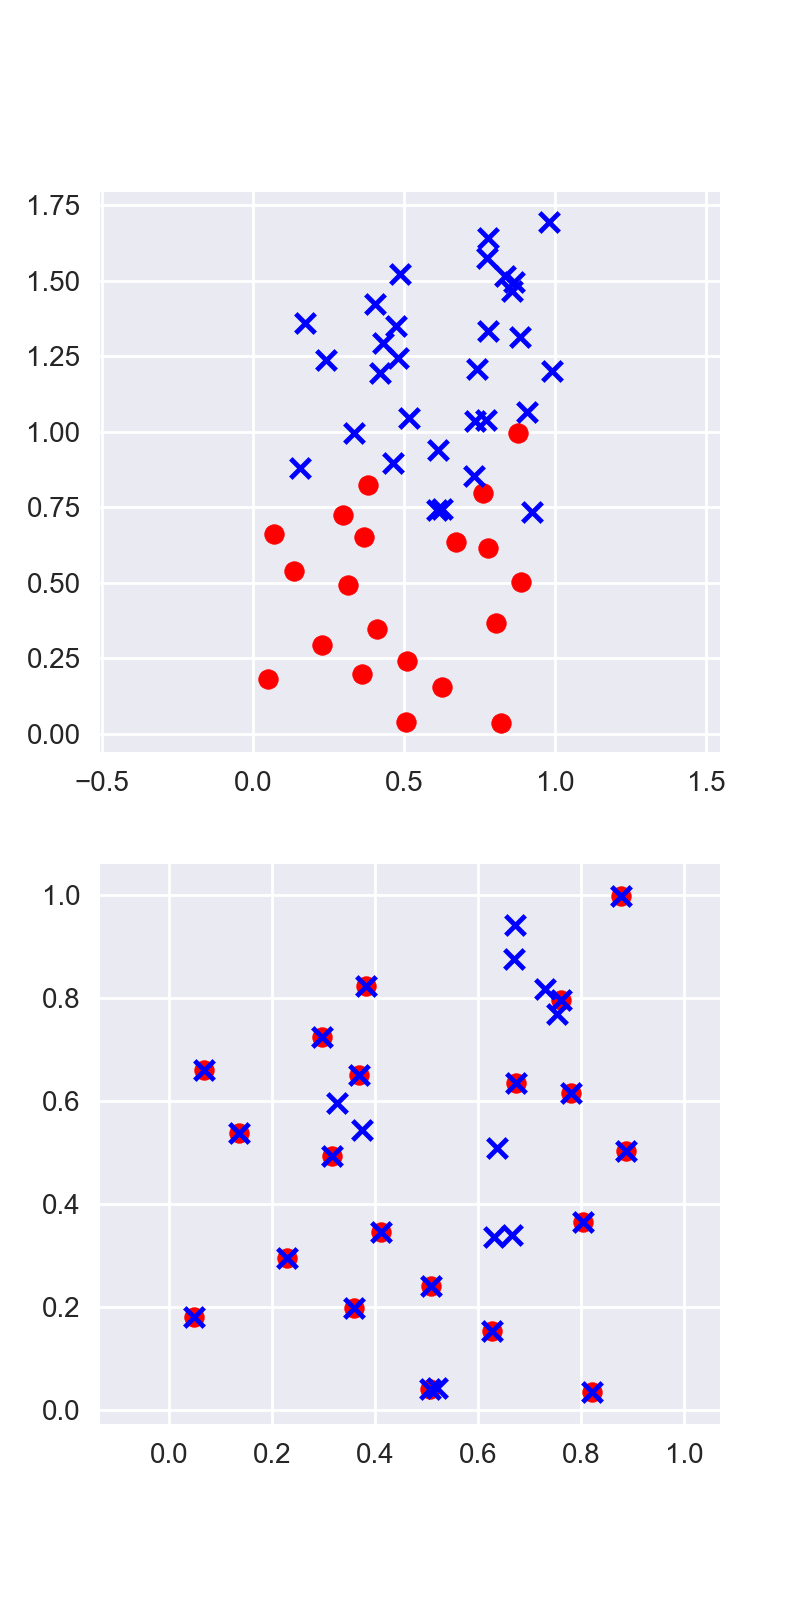

In [453]:
print(reg1.iteration)
print(reg2.iteration)
plot_results(ps1, ps2, result1[0])
plot_results(ps1, ps2, result2[0])

# Extra points

In [260]:
trans = np.random.rand(1, 2) * 1

realpnts = np.random.rand(50, 2)
ps1 = np.concatenate((realpnts, np.random.rand(20, 2)), axis=0)
ps2 = np.concatenate((realpnts, np.random.rand(20, 2)), axis=0) + trans

532
999


<IPython.core.display.Javascript object>


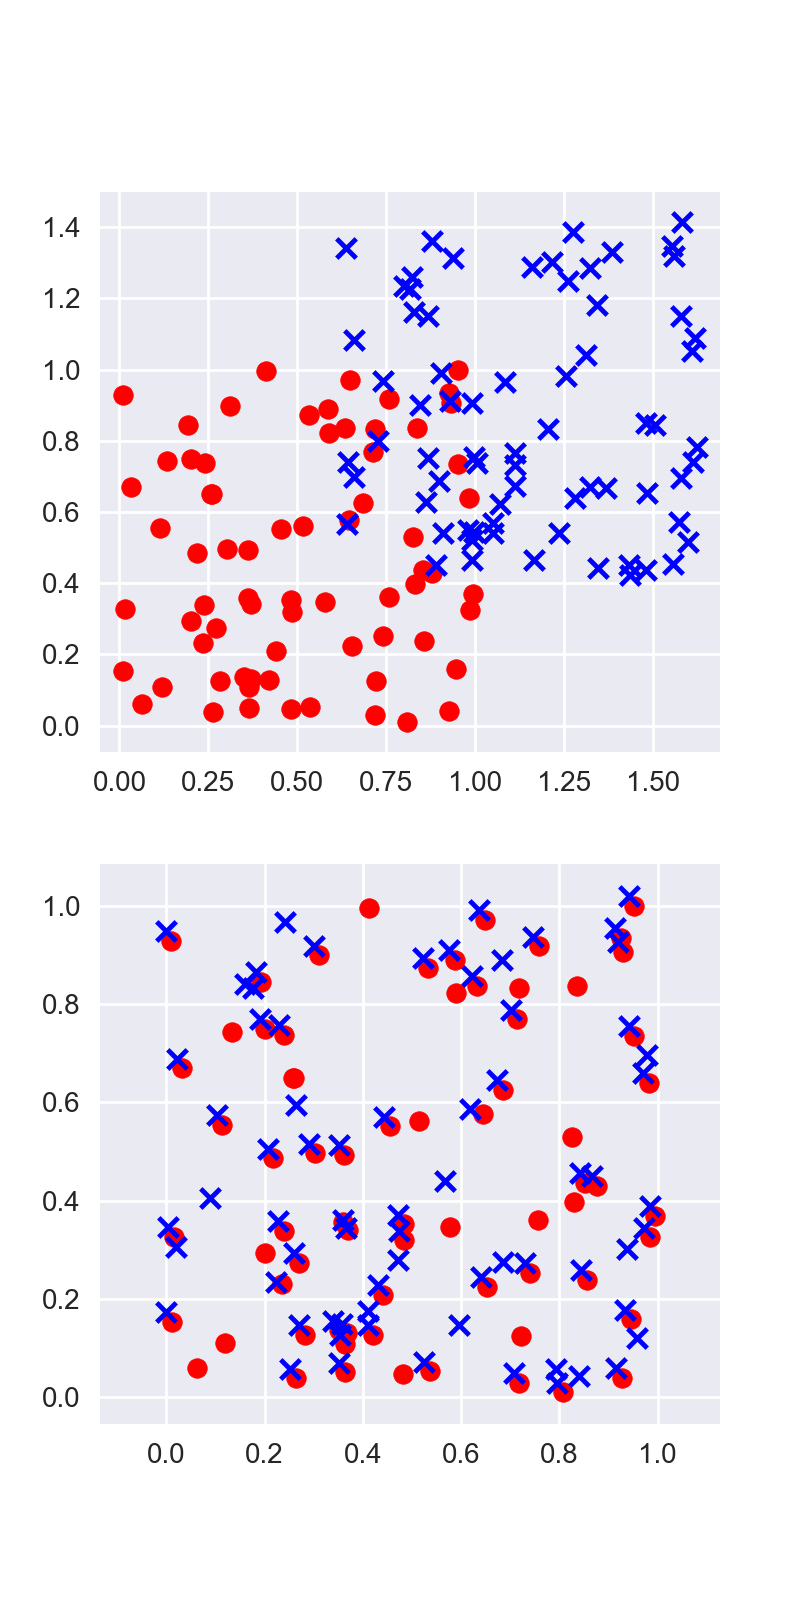

<IPython.core.display.Javascript object>


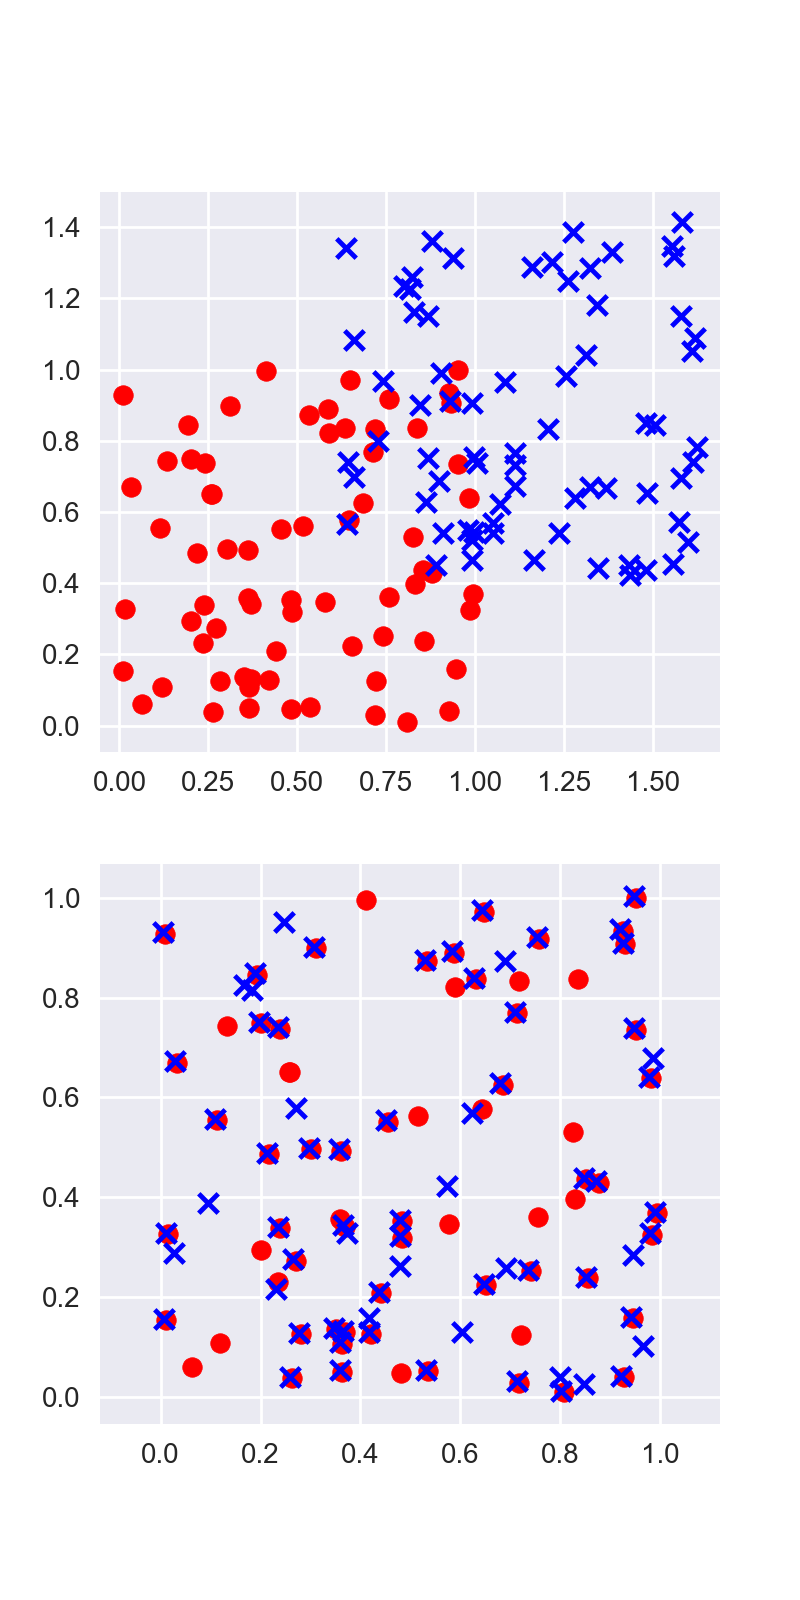

In [263]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0.2)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0.2, init_var=None, transform=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = TranslationCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    result1 = reg1.register(None)
    result2 = reg2(**kwargs2)
if not np.array_equal(result1[1], result2[1]):
    print(reg1.iteration)
    print(reg2.iteration)

    plot_results(ps1, ps2, result1[0])
    plot_results(ps1, ps2, result2[0])

## Jiggled points

In [290]:
trans = np.random.rand(1, 2) * 1

realpnts = np.random.rand(50, 2)
ps1 = realpnts + np.random.randn(*realpnts.shape)*0.02
ps2 = realpnts + np.random.randn(*realpnts.shape)*0.02 + trans

In [291]:
kwargs1 = dict(t=None, sigma2=None, maxIterations=1000, tolerance=1e-6, w=0.)
kwargs2 = dict(tol=1e-6, maxiters=1000, weight=0., init_var=None, transform=None)
reg1 = translation_registration(ps1, ps2, **kwargs1)
reg2 = TranslationCPD(ps1, ps2)

with np.errstate(invalid="raise"):
    result1 = reg1.register(None)
    result2 = reg2(**kwargs2)
if not np.allclose(result1[1], result2[1]):
    print(result1[1]-result2[1])
    print(reg1.iteration)
    print(reg2.iteration)

    plot_results(ps1, ps2, result1[0])
    plot_results(ps1, ps2, result2[0])

<IPython.core.display.Javascript object>


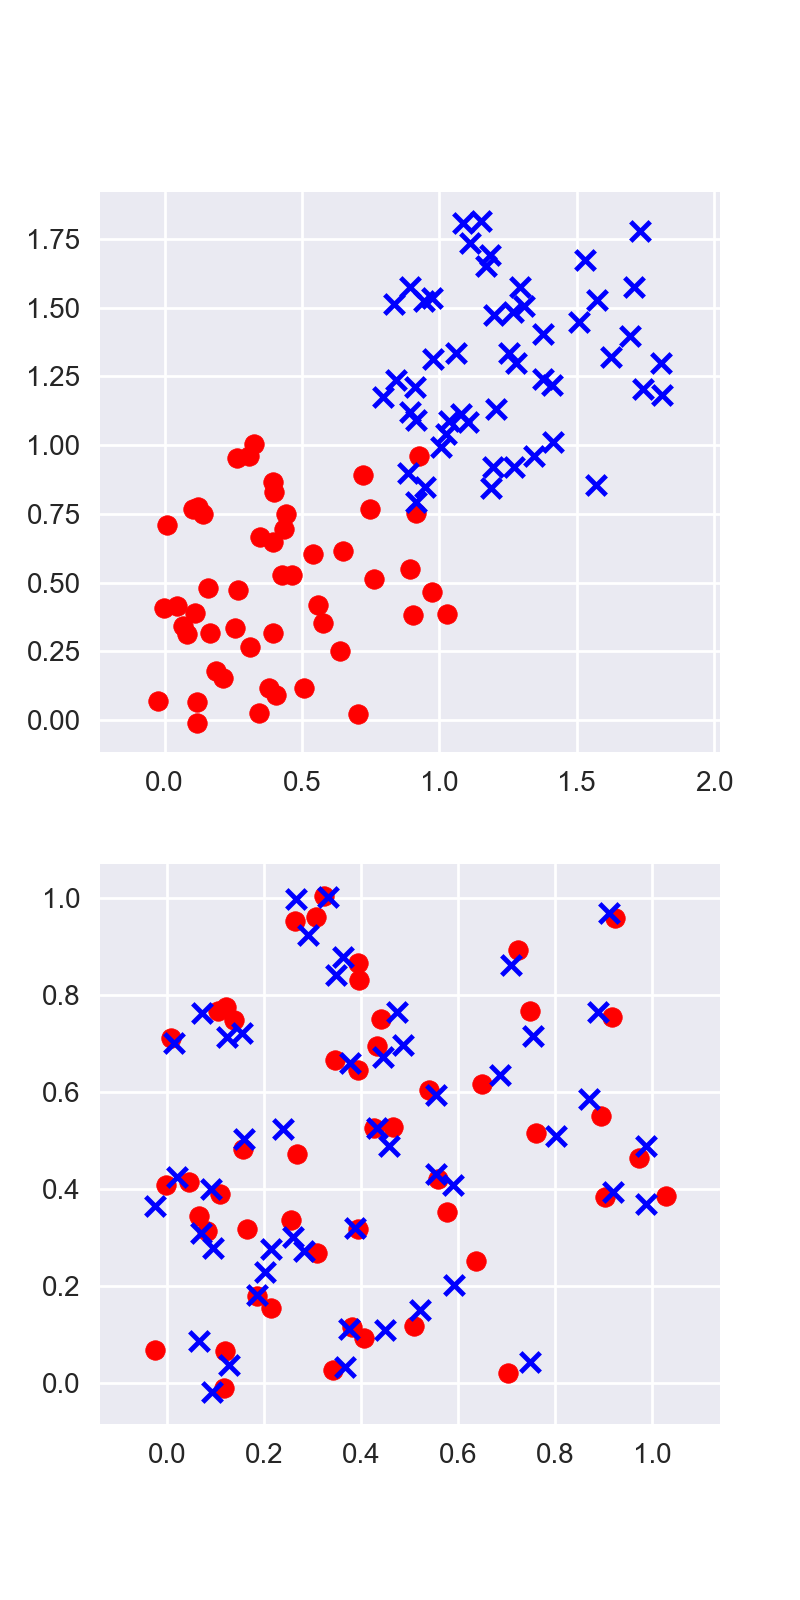

<IPython.core.display.Javascript object>


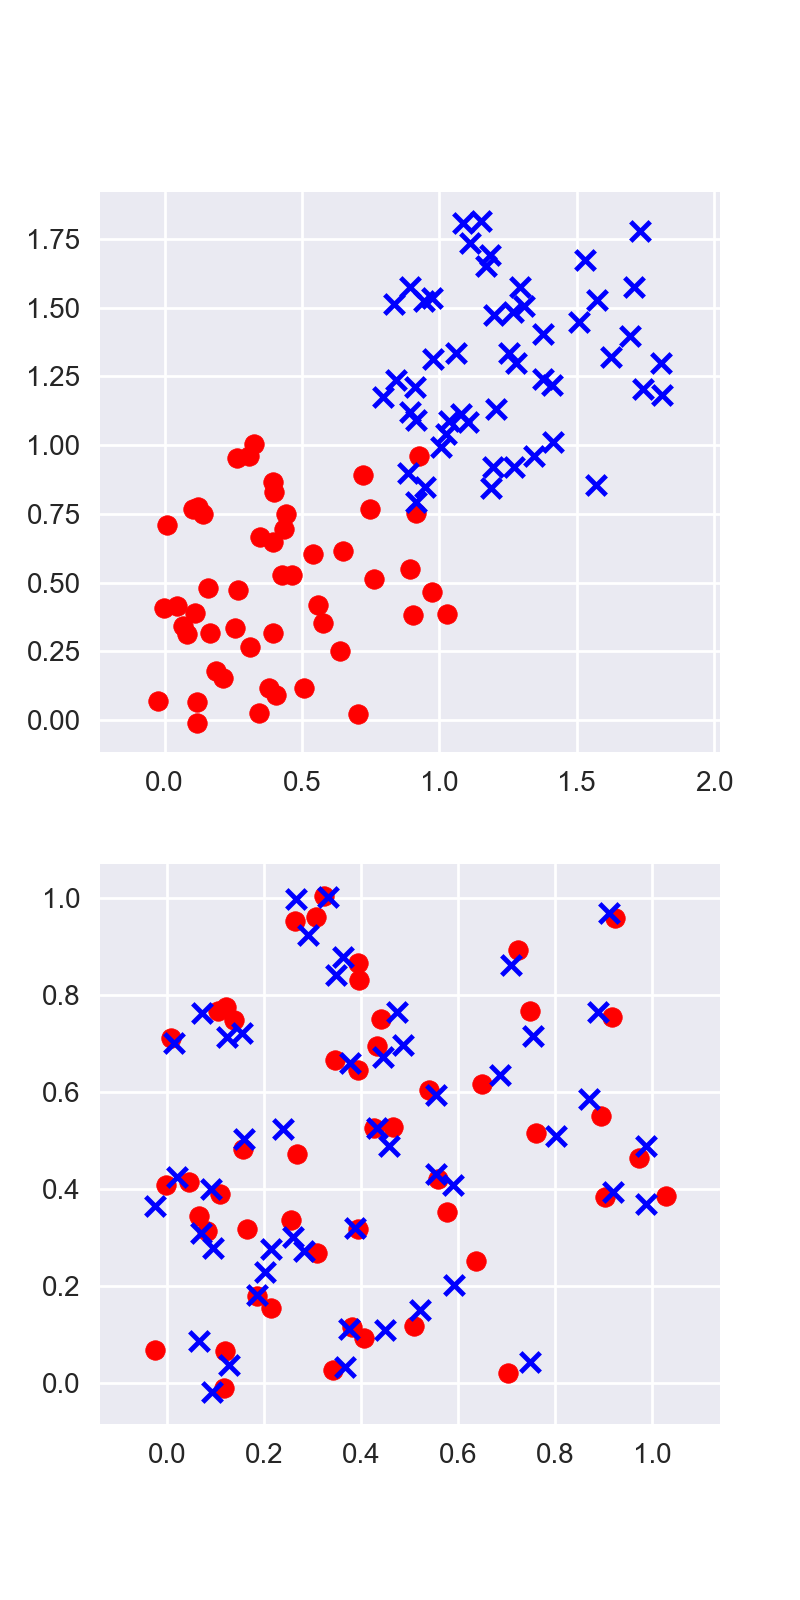

<IPython.core.display.Javascript object>


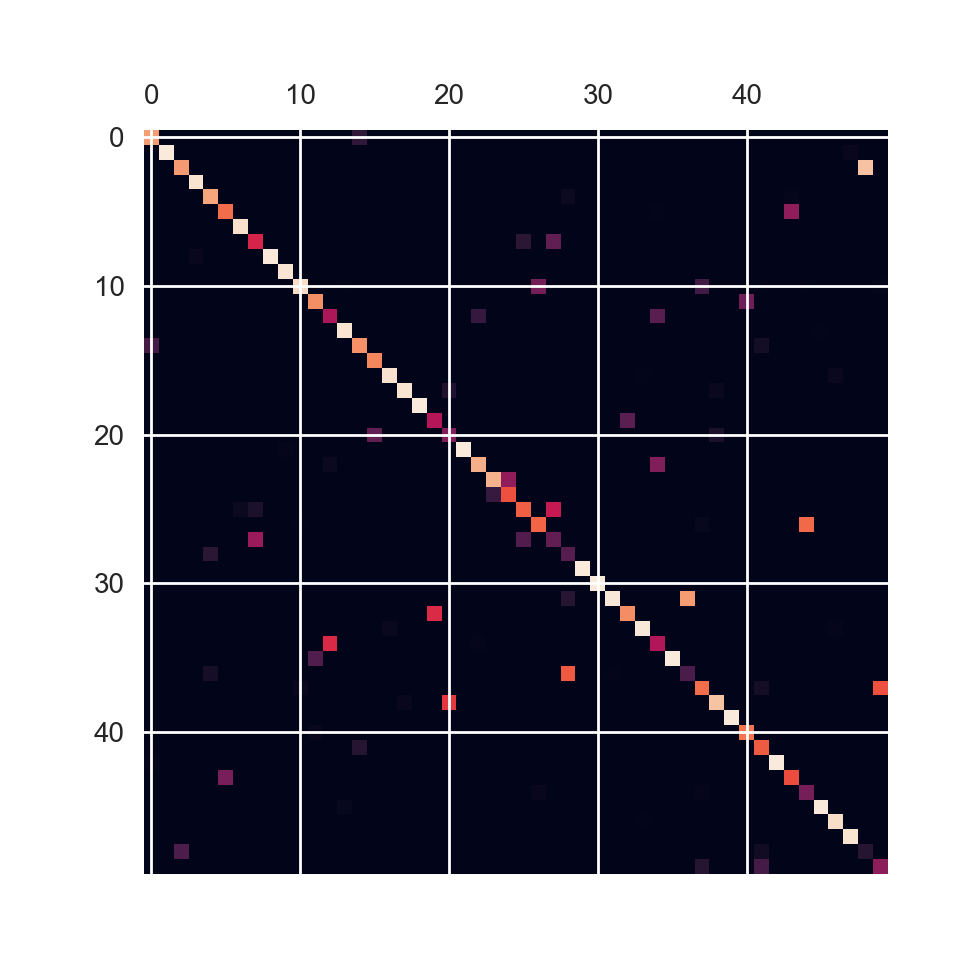

In [292]:
plot_results(ps1, ps2, result1[0])
plot_results(ps1, ps2, result2[0])
plt.matshow(reg2.p_old)